In [1]:
import devito
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Normal modeling

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


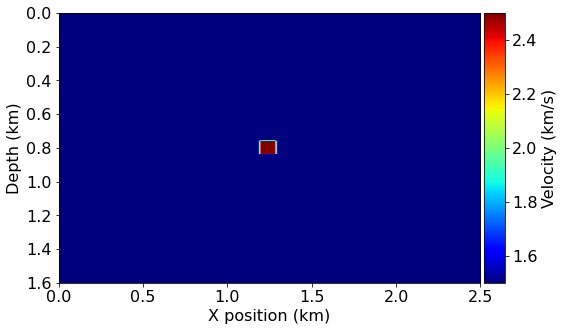

In [2]:
from examples.seismic import Model, plot_velocity

shape = (101, 201)
spacing = (25,8)
origin = (0., 0.)

vel = np.empty(shape, dtype=np.float32)
vel[:,:] = 1.5
vel[shape[0]//2-2:shape[0]//2+2, (shape[1]//2-5):(shape[1]//2+5)] = 2.5

model = Model(vp=vel, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=20, bcs="damp")
plot_velocity(model)

In [3]:
from examples.seismic import TimeAxis

t0 = 0.
tn = 3000.
dt = model.critical_dt

time_range = TimeAxis (start=t0, stop=tn, step=dt)

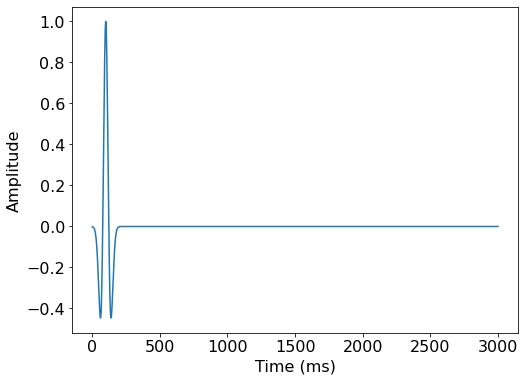

In [4]:
from examples.seismic import RickerSource

f0 = 0.010
src = RickerSource(name='src', grid=model.grid, f0=f0,
                  npoint=1, time_range=time_range)

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.

src.show()

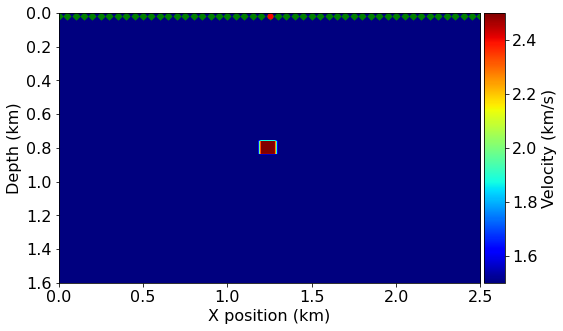

In [5]:
from examples.seismic import Receiver

rec = Receiver(name='rec', grid=model.grid, npoint=201, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:,0] = np.linspace(0, model.domain_size[0], num=201)
rec.coordinates.data[:,1] = 20.

plot_velocity(model, source=src.coordinates.data,
             receiver=rec.coordinates.data[::4, :])

In [6]:
from devito import TimeFunction

u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [7]:
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [8]:
src_term = src.inject (field=u.forward, expr=src * dt**2 / model.m)

rec_term = rec.interpolate(expr=u.forward)

In [9]:
from devito import Operator

op = Operator([stencil]+src_term + rec_term, subs=model.spacing_map)

In [10]:
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.30 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.2864029999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00017499999999999962, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.008933999999999888, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

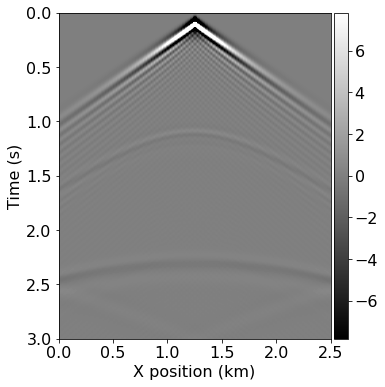

In [11]:
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

# Born modeling

Operator `smooth` ran in 0.01 s


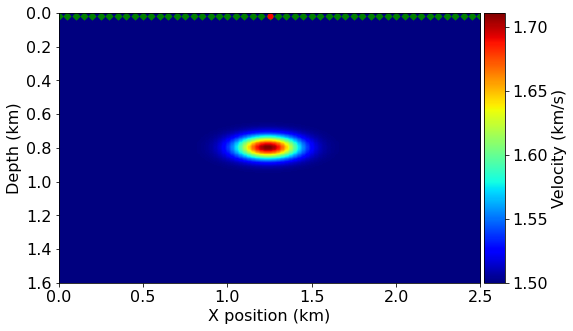

In [12]:
from devito import gaussian_smooth

filter_sigma = (5, 5)
model0 = model
gaussian_smooth(model0.vp, sigma=filter_sigma)
plot_velocity(model0, source=src.coordinates.data,
             receiver=rec.coordinates.data[::4, :])

In [13]:
u = TimeFunction(name='u', grid=model0.grid, save=None,
                time_order=2, space_order=2)
U = TimeFunction(name='U', grid=model0.grid, save=None,
                time_order=2, space_order=2)

In [14]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_image(data, vmin=None, vmax=None, colorbar=True, cmap="gray"):
    """
    Plot image data, such as RTM images or FWI gradients.

    Parameters
    ----------
    data : ndarray
        Image data to plot.
    cmap : str
        Choice of colormap. Defaults to gray scale for images as a
        seismic convention.
    """
    domain_size = 1.e-3 * np.array(model.domain_size)
    extent = [model.origin[0], model.origin[0] + domain_size[0],
              model.origin[1] + domain_size[1], model.origin[1]]
    plot = plt.imshow(np.transpose(data),
                      vmin=-.05,
                      vmax=.05,
                      cmap=cmap,extent=extent)
    
    plt.xlabel('X position (km)')
    plt.ylabel('Depth (km)')

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
    plt.show()

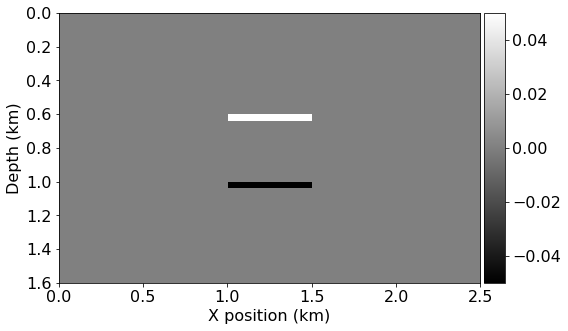

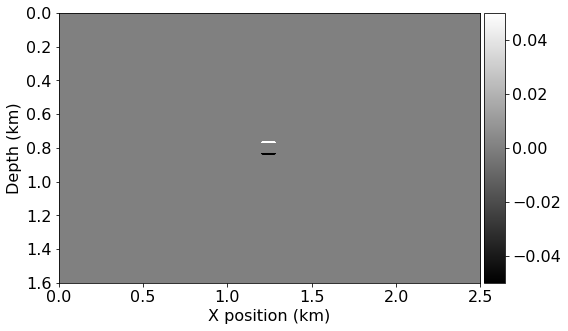

(141, 241)
(141, 241)


In [39]:
#slices=tuple(slice(model.nbl,-model.nbl) for _ in range(2))
#dm_true = (model.vp.data**(-2) - model0.vp.data**(-2))[slices]
#plot_image(np.diff(dm_true, axis=1))
shape = model0.grid.shape
dm_ref = np.zeros(shape,dtype=np.float32)
vel[shape[0]//2-2:shape[0]//2+2, (shape[1]//2-5):(shape[1]//2+5)] = 2.5
dm_ref[shape[0]//2-2:shape[0]//2+2, (shape[1]//2-5)] = 1
dm_ref[shape[0]//2-2:shape[0]//2+2, (shape[1]//2+5)] = -1

plot_image(dm_ref[shape[0]//2-10:shape[0]//2+10, (shape[1]//2-20):(shape[1]//2+20)])
plot_image(dm_ref)
print(dm_ref.shape)
print(model.grid.shape)

In [40]:
pdeBorn = model0.m * u.dt2 - u.laplace + model0.damp * u.dt
eq_forward = Eq(u.forward, solve(pdeBorn, u.forward), subdomain=model0.grid.subdomains['physdomain'])
eq_forward

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [41]:
from devito import Function
dm = Function(name="dm", grid=model0.grid, space_order=0)
q = -dm*u.dt2
pde_scatter = model0.m * U.dt2 - U.laplace + model0.damp * U.dt + q
solved = solve(pde_scatter,U.forward)
eq_scatter = Eq(U.forward, solve(pde_scatter,U.forward), subdomain=model0.grid.subdomains['physdomain'])
eq_scatter

Eq(U(t + dt, x, y), (-(-2.0*U(t, x, y)/dt**2 + U(t - dt, x, y)/dt**2)/vp(x, y)**2 + (-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2 + u(t + dt, x, y)/dt**2)*dm(x, y) + Derivative(U(t, x, y), (x, 2)) + Derivative(U(t, x, y), (y, 2)) + U(t, x, y)*damp(x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [42]:
model.grid

Grid[extent=(3500, 1920), shape=(141, 241), dimensions=(x, y)]

In [43]:
model.spacing_map

{h_x: 25.0, h_y: 8.0}

In [44]:
srcTermBorn = src.inject (field=u.forward, expr=src * dt**2 / model0.m)
recTermBorn = rec.interpolate(expr=U)

opBorn = Operator([eq_forward] + srcTermBorn + [eq_scatter] + recTermBorn,
             subs=model0.spacing_map,
             name='Born')

In [45]:
opBorn.apply(time=time_range.num-1, dt=model0.critical_dt, dm=dm_ref)

Operator `Born` ran in 0.69 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.29175599999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00017699999999999964, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.3851390000000008, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.009142999999999882, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

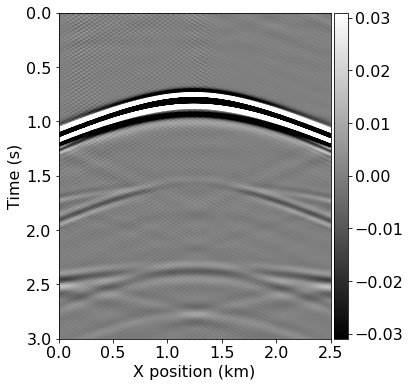

In [46]:
plot_shotrecord(rec.data, model0, t0, tn)